In [590]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [631]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    return df

In [632]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [633]:
for route in routes:
    add_extra_data(route)

In [634]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [595]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

# Data Analytics

## Helper Functions

In [596]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [597]:
import random

def random_date(start, end, prop):
    """
    Generates a random date in between the start and end date given
    """
    
    stime = convert_time_to_datetime(start)
    etime = convert_time_to_datetime(end)

    ptime = stime + prop * (etime - stime)
    return ptime

In [598]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

In [599]:
# Generate random list of request times
def generate_random_request_times(start, end, num_times):
    """
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    
    req_times_random = [random_date(start, end, random.random()) for x in range(num_times)]
    format = '%Y-%m-%d %H:%M:%S'
    req_times_random.sort()
    req_times = [t.strftime(format) for t in req_times_random]
    print(req_times)
    return req_times

## Predict journey time by taking recent information into account 

In [644]:
def get_times_past_2_hours(stop_a, stop_b, a_id, req_time):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past 2 hours 
        of the request time. (not including the request time)
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time. Returns -1
        if no vehicle arrived at stop b within the past 2 hours, but before the req_time. This
        could occur in cases where a request is made e.g. at 3 am and the bus is not a 24h bus.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past 2 hours 
        of the request time. Bus details include vehicle id.
    """

    journey_times = []
    most_recent_left = -1
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    count1 = 0
    count2 = 0

    for i, journey in stop_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        past_2_hours = req_time - dt.timedelta(hours = 2)

        if (arr_dt >= past_2_hours) & (arr_dt < req_time):
            count = count + 1
            # arrived within past 2 hours and before request time
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    # vehicle id matches
                    count1 = count1 + 1
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                        count2 = count2 + 1
                        most_recent_left = j
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        
    print("Number of buses that arrived at stop b within the past 2 hours: ", count)
    print("Number of buses that left stop a and have an id match: ", count1)
    print("Number of buses that have feasible journey times: ", count2)
        
    return most_recent_left, arrived_journeys, journey_times

In [651]:
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}

def predict_journey_time(req_time, stop_a, stop_b, a_id):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past 2 hours.
    - Journey times from the past 2 hours are weighted depending on how long ago
    they were compared to the request time.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    
    most_recent_left_indx, arrived, journey_times = get_times_past_2_hours(stop_a, stop_b, a_id, req_time)
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["time_of_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [660]:
def predict_arrival_time(req_time, leave_stop, pred_jrny_time, most_recent_left):
    """
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred_jrny_time: predicted journey time
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """
    
    req_time = convert_time_to_datetime(req_time)

    for i, bus in leave_stop.iterrows():
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            leave_time = convert_time_to_datetime(bus['time_of_arrival'])
            # This vehicle is the one that left immediately after

            if leave_time <= req_time:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred_jrny_time + 30))
                return pred_arrival, bus
            # else: The nearest vehicle left stop a after the request time, so this wouldn't count as historical data
            break
                
    # most_recent_left is the last item in the list already
    print("There are no buses due at this time from this stop")    
    return 0, []

In [689]:
def get_actual_times(arr_stop, req_time, bus_to_track, arr_stop_id):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    
    Returns the arrival time and journey time of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    [bus_id, a_id, date, direction, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_' + direction + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                if (actual_jrny_time > dt.timedelta(minutes = 10)) or (actual_jrny_time < dt.timedelta(minutes = 3)):
                    return -1, -1
                
                print("Actual journey time is {}".format(actual_jrny_time))
                print("Actual arrival time is {}".format(actual_arr_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [680]:
def pred_eval_arrival_times_mult(req_time, stop_a, stop_b, a_id, b_id):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B.
    If the actual bus data cannot be found, the actual arrival time = 0.
    
    """
    
    print("Request time is ", req_time)
    
    pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a, stop_b, a_id)
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        print("Couldn't find any journeys")
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        print("Cannot find correlating leaving bus.")
        return pred_arr, 0, 0, 0
    
    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr, actual_jrny_time = get_actual_times(stop_b, req_time, bus_to_track, b_id)
    
    if actual_arr == -1:
        print("There is no bus arriving at req_time")
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

### Route 52 Gap of 5: Chesterton Road to Nottinghill Gate Station (inbound)

I am at Nottinghill Gate Station and I want to know what time the next bus will arrive. The current time is X.

I look back 5 stops to find stop A which is the stop which I will use to predict the journey time. Here stop A = Chesterton Road.

I look at the other buses that have left Chesterton Road and arrived at Nottinghill Gate Station in the past 2 hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes. Then calculate this weighted average as the predicted journey time for a bus travelling between Chesterton Road and Nottinghill Gate. **predicted journey time = weighted average of past 2 hours of journey times**

I now try to get the predicted arrival time. So I look for the last bus to leave Chesterton Road and arrive at Nottinghill Gate before the request time. Then I get the next immediate bus that leaves Chesterton Road. This is the one that will be used to predict the arrival time. Add the predicted journey time onto the leave time of this bus + 30 seconds loading/unloading time to get the predicted arrival time. **predicted arrival time = leave time + predicted journey time + 30 seconds**. 

If such a bus doesn't exist, then there is no predicted arrival time, but there is still the predicted journey time. E.g. if I request the time that the nearest bus will arrive at Nottinghill Gate at 03:16:27, then I gather all the buses that arrived at Nottinghill Gate within the past 2 hours that arrived BEFORE 03:16:27. Say the last bus that left Chesterton Road left at 02:45 and arrived at Nottinghill Gate at 03:15. So to get the predicted arrival time, I try to find the next bus to leave Chesterton Road, which is a bus that leaves at 03:17. This time is AFTER the request time so I cannot use this bus in the prediction because it is not the historical data.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

I now get the actual arrival time. The same bus that we used to calculate the predicted arrival time, we track its vehicle id in the entries for Nottinghill Gate and look for its actual arrival time. Get the actual journey time by subtracting the leave time from the actual arrival time. **actual journey time = actual arrival time - leave time**

To evaluate success, plot the predicted journey journey time against the actual journey time and could calculate the MAPE or something along those lines.

In [681]:
stop_a_name = stops_in_sequence_inbound.get("52")[16]
stop_b_name = stops_in_sequence_inbound.get("52")[21]

print(stop_a_name, stops_in_sequence_inbound.get("52").index("Chesterton Road"))
print(stop_b_name, stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

Chesterton Road 16
Notting Hill Gate Station 21


In [682]:
b_52 = data["52"]

stop_a = b_52.loc[(b_52['bus_stop_name'] == stop_a_name) & (b_52['direction'] == 'inbound')]
[_, stop_a_id, _, _, _] = stop_a.iloc[0]['vehicle_id'].split('_')
print(stop_a.shape)
print(stop_a_id)
stop_a.head()

(1351, 5)
490005139C


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
24,Chesterton Road,2020-04-16 02:53:40,11536_490005139C_2020-04-16_out_0,2020-04-16 02:49:22,inbound
98,Chesterton Road,2020-04-16 03:24:17,10292_490005139C_2020-04-16_out_0,2020-04-16 03:21:47,inbound
147,Chesterton Road,2020-04-16 03:41:35,11808_490005139C_2020-04-16_out_0,2020-04-16 03:40:29,inbound
209,Chesterton Road,2020-04-16 03:58:22,10271_490005139C_2020-04-16_out_0,2020-04-16 03:50:09,inbound
225,Chesterton Road,2020-04-16 03:52:49,11744_490005139C_2020-04-16_out_0,2020-04-16 03:40:29,inbound


In [674]:
stop_b = b_52.loc[(b_52['bus_stop_name'] == stop_b_name) & (b_52['direction'] == 'inbound')]
[_, stop_b_id, _, _, _] = stop_b.iloc[0]['vehicle_id'].split('_')
print(stop_b.shape)
print(stop_b_id)
stop_b.head()

(1360, 5)
490000167G


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
32,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
110,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
159,Notting Hill Gate Station,2020-04-16 03:45:43,11808_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound
219,Notting Hill Gate Station,2020-04-16 03:57:20,11744_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound
233,Notting Hill Gate Station,2020-04-16 04:00:00,10271_490000167G_2020-04-16_out_0,2020-04-16 03:57:30,inbound


In [690]:
# Getting predicted arrival times for buses on route 52 for a gap of 5 stops.
"""
preds_52 = predicted arrival times
accs_52 = actual arrival times
req_timesx_52 = request times that returned valid values
preds_jrny_52 = predicted journey times (in minutes)
accs_jrny_52 = actual journey times (in minutes)
"""

preds_52 = []
accs_52 = []
req_times_52 = generate_random_request_times("2020-04-16 03:00:00", "2020-05-07 23:59:59", 200)
req_timesx_52 = []
preds_jrny_52 = []
accs_jrny_52 = []

start = time.time()
for req_time in req_times_52:
    pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, stop_a, stop_b, stop_a_id, stop_b_id)
    if at == 0:
        continue
        
    req_timesx_52.append(req_time)
    preds_52.append(pt)
    accs_52.append(at)
    preds_jrny_52.append(pj / 60)
    accs_jrny_52.append(aj / 60)
print("Total time taken: ", (time.time() - start))

['2020-04-16 05:37:29', '2020-04-16 06:31:05', '2020-04-16 06:38:55', '2020-04-16 10:33:30', '2020-04-16 11:54:55', '2020-04-16 12:33:12', '2020-04-16 12:58:52', '2020-04-16 15:38:10', '2020-04-16 16:33:25', '2020-04-16 18:12:21', '2020-04-16 18:58:38', '2020-04-16 20:35:06', '2020-04-16 22:26:04', '2020-04-17 00:14:23', '2020-04-17 03:21:47', '2020-04-17 06:52:53', '2020-04-17 07:40:35', '2020-04-17 10:32:19', '2020-04-17 12:44:38', '2020-04-17 14:34:31', '2020-04-17 19:00:32', '2020-04-17 19:45:28', '2020-04-18 02:21:12', '2020-04-18 11:57:23', '2020-04-18 16:21:41', '2020-04-18 17:12:04', '2020-04-18 17:28:52', '2020-04-18 17:31:35', '2020-04-18 18:34:51', '2020-04-18 22:27:52', '2020-04-19 00:39:02', '2020-04-19 05:22:55', '2020-04-19 07:40:36', '2020-04-19 10:42:11', '2020-04-19 11:44:24', '2020-04-19 15:21:42', '2020-04-19 22:15:54', '2020-04-19 23:31:09', '2020-04-20 00:28:55', '2020-04-20 01:45:35', '2020-04-20 02:04:02', '2020-04-20 02:07:43', '2020-04-20 04:33:51', '2020-04-2

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-16 22:26:04
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  20
Number of buses that have feasible journey times:  4
Predicted journey time is  5.233333333333333
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-17 00:14:23
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 03:21:47
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and h

Number of buses that arrived at stop b within the past 2 hours:  16
Number of buses that left stop a and have an id match:  160
Number of buses that have feasible journey times:  32
Predicted journey time is  3.7867901234567913
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-19 23:31:09
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  180
Number of buses that have feasible journey times:  28
Predicted journey time is  4.013461538461538
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-20 00:28:55
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and have an id match:  104
Number of buses that have feasible journey times:  16
Predicted journey time is  4.257142857142855
There are no buses due at this time from this stop
Cannot find correl

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-23 12:21:26
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-23 12:25:40
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-23 13:36:11
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-26 01:20:29
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-26 02:04:30
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-26 08:40:55
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-28 19:35:43
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-28 19:36:22
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-29 08:36:46
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-02 09:58:45
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-02 10:27:11
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-02 10:38:26
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  43
Number of buses that have feasible journey times:  7
Predicted journey time is  5.39320987654321
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-05 08:17:00
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  11
Predicted journey time is  5.91269230769231
Predicted arrival time is 2020-05-05 08:12:06.761538
There is no bus arriving at req_time
Request time is  2020-05-05 10:13:50
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  76
Number of buses that have feasible journey times:  11
Predicted journey time is  5.198252688172043
There are no buses due at this time from this stop
Cannot find correlating

Number of buses that arrived at stop b within the past 2 hours:  7
Number of buses that left stop a and have an id match:  39
Number of buses that have feasible journey times:  7
Predicted journey time is  5.3848765432098755
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-07 22:24:47
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-07 23:56:40
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  5.8999999999999995
Predicted arrival time is 2020-05-07 23:59:27
There is no bus arriving at req_time
Total time taken:  524.1746900081635


In [691]:
len(preds_jrny_52)

21

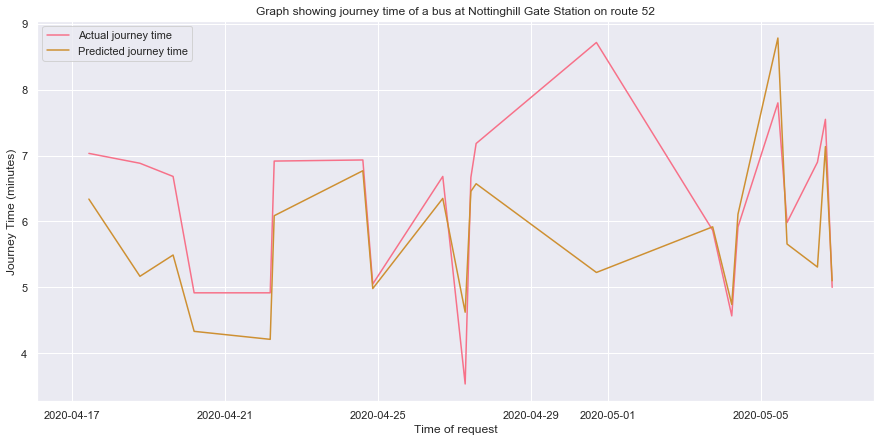

In [693]:
times_52 = [convert_time_to_datetime(t) for t in req_timesx_52]
actual_jrny_52 = [x.total_seconds() for x in accs_jrny_52]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_52, actual_jrny_52, label="Actual journey time")
ax.plot(times_52, preds_jrny_52, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_xlim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 5, 7, 22, 59, 59)])
ax.set_title("Graph showing journey time of a bus to Nottinghill Gate Station on route 52")
ax.legend()

plt.show()

### Measuring Success

**Explained variance regression score function**: Best possible score is 1.0, lower values are worse. https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score 

**Mean Absolute Percentage Error:** (MAPE). Best is 1, lower values are worse.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

In [695]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

actual_seconds_52 = [a.timestamp() for a in accs_52]
pred_seconds_52 = [p.timestamp() for p in preds_52]

evs = explained_variance_score(actual_seconds_52, pred_seconds_52)
mape = mean_absolute_error(actual_seconds_52, pred_seconds_52)

print("Explain variance score: ", evs)
print("Mean absolute percentage error: ", mape)

Explain variance score:  0.9999999895178368
Mean absolute percentage error:  53.271510998408


### Different gaps for predictions for bus route 52

Experiment with different gaps to report back

In [697]:
print("Number of stops in route 52: ", len(stops_in_sequence_inbound.get("52")))
stop_a = stops_in_sequence_inbound.get("52")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_inbound.get("52")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_inbound.get("52")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_inbound.get("52")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_inbound.get("52")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_inbound.get("52")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_inbound.get("52")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_inbound.get("52")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_15, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a)
print("destination stops: ", destination_stops)

Number of stops in route 52:  37
origin stop:  Willesden Bus Garage
destination stops:  ['Okehampton Road', 'Harrow Road / Kilburn Lane', 'Chesterton Road', 'Notting Hill Gate Station', 'Palace Gate', 'Knightsbridge Station  / Harrods', 'Victoria Bus Station']


In [698]:
stop_a_entries = b_52.loc[(b_52['bus_stop_name'] == stop_a) & (b_52['direction'] == 'inbound')]
[_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id)

(1208, 5)
490014687E


In [699]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

full_preds_varying_gaps = []
full_actual_varying_gaps = []
full_req_varying_gaps = []

req_times_52 = generate_random_request_times("2020-04-16 03:00:00", "2020-05-07 23:59:59", 50)

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == destination_stops[i]) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')

    preds_52 = []
    accs_52 = []
    req_timesx_52 = []

    for req_time in req_times_52:
        pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, stop_a_entries, stop_b_entries, stop_a_id, stop_b_id)
        if at == 0:
            continue
            
        req_timesx_52.append(req_time)
        preds_52.append(pj)
        accs_52.append(aj)
        
    full_preds_varying_gaps.append(preds_52)
    full_actual_varying_gaps.append(accs_52)
    full_req_varying_gaps.append(req_timesx_52)

['2020-04-16 07:42:30', '2020-04-16 12:07:27', '2020-04-16 21:06:07', '2020-04-17 09:36:10', '2020-04-18 04:07:35', '2020-04-18 15:54:07', '2020-04-18 19:30:26', '2020-04-18 23:19:40', '2020-04-19 15:58:48', '2020-04-19 19:33:05', '2020-04-20 07:51:44', '2020-04-20 09:26:58', '2020-04-20 12:49:58', '2020-04-21 00:35:31', '2020-04-21 09:58:45', '2020-04-21 12:19:40', '2020-04-21 19:19:13', '2020-04-22 11:37:40', '2020-04-22 13:14:04', '2020-04-23 01:32:43', '2020-04-23 12:41:57', '2020-04-23 15:10:50', '2020-04-25 07:45:21', '2020-04-25 07:51:36', '2020-04-25 08:17:12', '2020-04-26 10:17:24', '2020-04-27 10:22:27', '2020-04-27 10:28:08', '2020-04-27 13:23:19', '2020-04-27 18:55:05', '2020-04-28 05:38:29', '2020-04-29 20:59:02', '2020-04-30 05:33:48', '2020-04-30 06:44:36', '2020-04-30 14:36:47', '2020-04-30 23:08:36', '2020-05-01 08:03:55', '2020-05-01 23:49:55', '2020-05-02 08:38:40', '2020-05-03 08:23:45', '2020-05-03 22:44:35', '2020-05-04 17:14:37', '2020-05-05 05:48:45', '2020-05-0

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-25 08:17:12
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-26 10:17:24
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 10:22:27
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  10


Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  8
Predicted journey time is  6.81258865248227
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-05-06 19:01:45
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  2
Predicted journey time is  2.723333333333333
Predicted arrival time is 2020-05-06 18:10:50.400000
There is no bus arriving at req_time
Request time is  2020-04-16 07:42:30
Number of buses that arrived at stop b within the past 2 hours:  22
Number of buses that left stop a and have an id match:  148
Number of buses that have feasible journey times:  40
Predicted journey time is  9.271273712737129
Predicted arrival time is 2020-04-16 07:49:17.276423
There is no bus arriv

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 10:22:27
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  10
Predicted journey time is  9.346246246246247
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-27 10:28:08
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  10
Predicted journey time is  9.303993055555557
Predicted arrival time is 2020-04-27 10:32:18.239583
There is no bus arriving at req_time
Request time is  2020-04-27 13:23:19
Number of buses that ar

There is no bus arriving at req_time
Request time is  2020-04-16 07:42:30
Number of buses that arrived at stop b within the past 2 hours:  22
Number of buses that left stop a and have an id match:  148
Number of buses that have feasible journey times:  24
Predicted journey time is  12.916666666666668
Predicted arrival time is 2020-04-16 07:52:56
There is no bus arriving at req_time
Request time is  2020-04-16 12:07:27
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  100
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-16 21:06:07
Number of buses that arrived at stop b within the past 2 hours:  2
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 09:36:10
Number of buses that arrived

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 18:55:05
Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  69
Number of buses that have feasible journey times:  2
Predicted journey time is  14.652380952380952
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-28 05:38:29
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-29 20:59:02
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-18 15:54:07
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-18 19:30:26
Number of buses that arrived at stop b within the past 2 hours:  18
Number of buses that left stop a and have an id match:  80
Number of buses that have feasible journey times:  4
Predicted journey time is  0.46666666666666673
Predicted arrival time is 2020-04-18 19:03:43
There is no bus arriving at req_time
Request time is  2020-04-18 23:19:40
Number of buses that arrived at stop b within the past 2 hours:  8
Number of buses that left stop a and hav

Number of buses that arrived at stop b within the past 2 hours:  9
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-30 23:08:36
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-01 08:03:55
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-01 23:49:55
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
P

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-21 12:19:40
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-21 19:19:13
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-22 11:37:40
Number of buses that arrived at stop b within the past 2 hours:  20
Number of buses that left stop a and have an id match:  168
Number of buses that have feasible journey times:  0


Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  63
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-05 11:51:18
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 04:20:07
Number of buses that arrived at stop b within the past 2 hours:  3
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-06 12:53:49
Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times: 

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-26 10:17:24
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 10:22:27
Number of buses that arrived at stop b within the past 2 hours:  11
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-27 10:28:08
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  89
Number of buses that have feasible journey times:  0

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-18 19:30:26
Number of buses that arrived at stop b within the past 2 hours:  16
Number of buses that left stop a and have an id match:  72
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-18 23:19:40
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  48
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-19 15:58:48
Number of buses that arrived at stop b within the past 2 hours:  20
Number of buses that left stop a and have an id match:  208
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 2 hours:  5
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-01 08:03:55
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-01 23:49:55
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-05-02 08:38:40
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pr

5


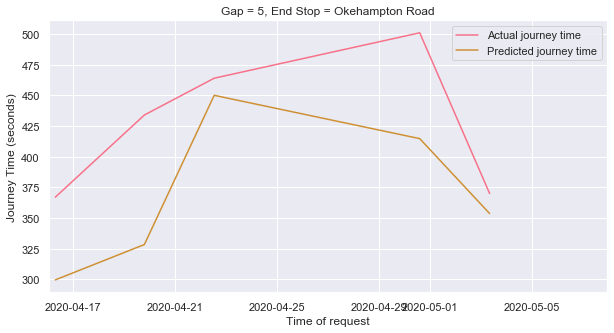

0


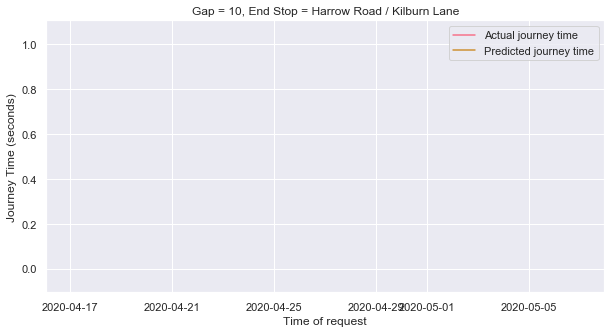

0


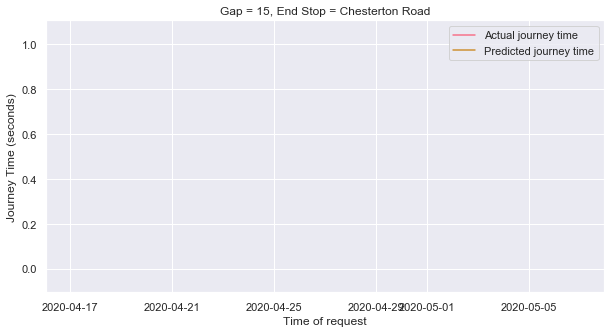

0


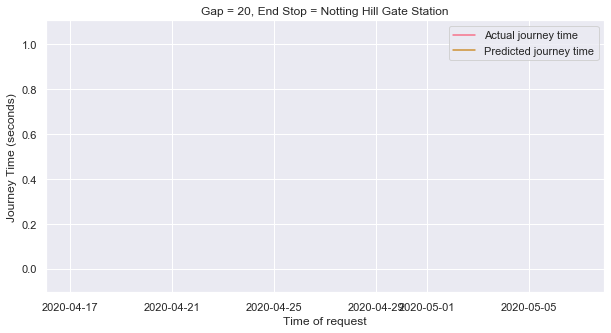

0


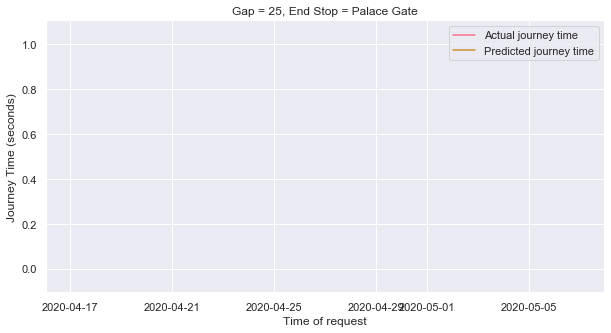

0


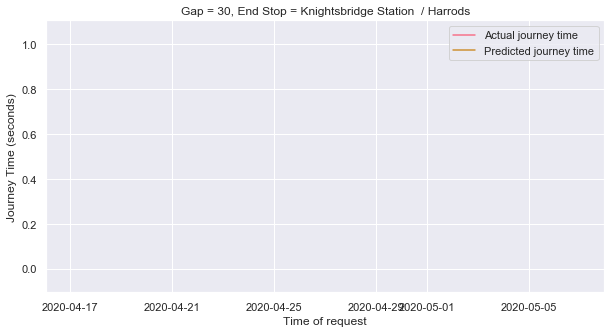

0


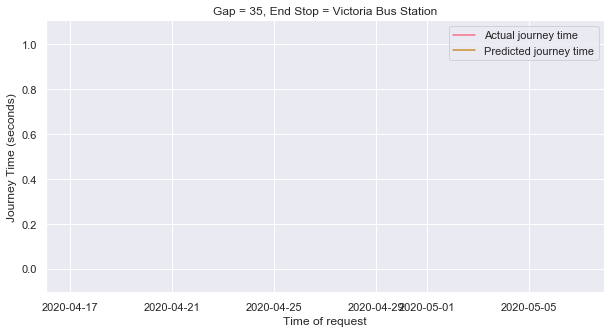

In [707]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = [x.total_seconds() for x in full_actual_varying_gaps[i]]
    t = full_req_varying_gaps[i]
    r = [convert_time_to_datetime(x) for x in t]
    print(len(p))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(r, a, label="Actual journey time")
    ax.plot(r, p, label="Predicted journey time")
    ax.set_xlabel("Time of request")
    ax.set_ylabel("Journey Time (seconds)")
    ax.set_xlim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 5, 7, 22, 59, 59)])
    ax.set_title("Gap = {}, End Stop = {}".format((i + 1) * 5, destination_stops[i]))
    ax.legend()
    plt.show()

In [451]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = full_actual_varying_gaps[i]
    t = full_req_varying_gaps[i]
    actual_seconds_52 = [x.timestamp() for x in a]
    pred_seconds_52 = [x.timestamp() for x in p]
    evs = explained_variance_score(actual_seconds_52, pred_seconds_52)
    mape = mean_absolute_error(actual_seconds_52, pred_seconds_52)

    print("Gap = {} Explain variance score = {}, MAPE = ".format((i + 1) * 5, evs, mape))

Gap = 5 Explain variance score = 0.999914196340387
Gap = 10 Explain variance score = 0.999607017570896
Gap = 15 Explain variance score = 0.9988003937122831
Gap = 20 Explain variance score = 0.9194859215288302
Gap = 25 Explain variance score = 0.849248737652785
Gap = 30 Explain variance score = 0.0


### Putting it all together

The user gives their desired bus stop and bus route and gets a predicted arrival time back.

In [508]:
def get_pred_and_actual_arrival_time(route, stop):
    # Will need to do something about inbound or outbound
    
    df = data[route]

    stop_b_entries = df.loc[(df['bus_stop_name'] == stop) & (df['direction'] == 'inbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    b_stop_index = stops_in_sequence_inbound.get(route).index(stop)
    a_stop_index = b_stop_index - 5 if (b_stop_index - 5) >= 0 else 0 
    a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
    print("{} to {}".format(a_stop_name, stop))
    
    stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
    [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
    
    # req_time = dt.datetime.now()
    req_time = "2020-05-12 07:30:00"
    
    print("Request time is ", req_time)
    
    pred_arr = 0
    
    while pred_arr == 0:
        pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a_entries, stop_b_entries, stop_a_id)
        print("Predicted journey time is ", (pred_jrny_time)/60)
        
        if pred_jrny_time == 0:
            print("Unable to find any journeys")
            pred_arr = 0
        else:
            pred_arr, bus_to_track = pred_arrival_time(req_time, stop_a_entries, pred_jrny_time, most_recent_left)

        
        if pred_arr == 0:
            print("Couldn't find correlating leaving bus, go back 1 more stop")
            a_stop_index = a_stop_index - 1

            if a_stop_index < 0:
                print("No journeys found on entire route")
                return 0, 0

            a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
            stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
            [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
            print("{} to {}".format(a_stop_name, stop))

    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr = get_actual(stop_b_entries, req_time)
    
    if actual_arr is None:
        print("There is no bus arriving at req_time")
        return pred_arr, 0
    
    return pred_arr, actual_arr

In [500]:
user_route = "267"
user_stop = "Ravenscourt Park"

predicted_arr_time, actual_arr_time = get_pred_and_actual_arrival_time(user_route, user_stop)

Clifton Gardens to Ravenscourt Park
Request time is  2020-05-12 07:30:00
most recent left bus left at  2020-05-12 07:20:06
Predicted journey time is  4.005357142857143
leave time =  2020-05-12 07:38:18
There are no more buses due
Couldn't find correlating leaving bus, go back 1 more stop
Turnham Green Church to Ravenscourt Park
most recent left bus left at  2020-05-12 07:19:02
Predicted journey time is  5.251785714285715
leave time =  2020-05-12 07:37:48
There are no more buses due
Couldn't find correlating leaving bus, go back 1 more stop
Chiswick Road to Ravenscourt Park
most recent left bus left at  2020-05-12 07:17:46
Predicted journey time is  6.445436507936509
leave time =  2020-05-12 07:37:05
There are no more buses due
Couldn't find correlating leaving bus, go back 1 more stop
Gunnersbury Station to Ravenscourt Park
Predicted journey time is  0.0
Unable to find any journeys
Couldn't find correlating leaving bus, go back 1 more stop
Thorney Hedge Road to Ravenscourt Park
most re